In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from PIL import Image
import time
from torchvision.models import resnet50
from torchvision.models import vgg16
from torchvision.models import alexnet
from torchvision.models import densenet121
from sklearn.metrics import confusion_matrix

In [ ]:
image_data = "Train_Test_file/Sports_Classes"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(image_data, 'train'), transform=transform)

val_dataset = datasets.ImageFolder(os.path.join(image_data, 'val'), transform=transform)

test_dataset = datasets.ImageFolder(os.path.join(image_data, 'test'), transform=transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **VGG 16**

In [ ]:
model = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**First combination**

In [ ]:
model.classifier[6] = nn.Sequential(
    nn.Linear(4096,10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10,7)
)

In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()
    strat_time = time.time()

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

model.eval()
running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss

test_loss = running_loss / len(test_loader)
test_losses.append(test_loss)
test_accuracy = 100 * correct / total

print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Second combination**

In [ ]:
model1 = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model1.classifier[6] = nn.Sequential(
    nn.Linear(4096,10),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(10,7)
)

In [ ]:
model1.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses1 = []
val_losses1 = []
test_losses1 = []

for epoch in range(num_epochs):
    start_time = time.time()

    model1.train()
    running_loss1 = 0.0
    correct1 = 0
    total1 = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer1.zero_grad()
        outputs = model1(inputs)

        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        running_loss1 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy1 = 100 * correct1 / total1
    train_loss1 = running_loss1 / len(train_loader)
    train_losses1.append(train_loss1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss1:.4f}, Train Accuracy: {train_accuracy1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    model1.eval()
    running_loss1 = 0.0
    correct1 = 0
    total1 = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model1(inputs)
            loss = criterion1(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total1 += labels.size(0)
            correct1 += (predicted == labels).sum().item()
            running_loss1 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss1 = running_loss1 / len(val_loader)
    val_losses1.append(val_loss1)
    val_accuracy1 = 100 * correct1 / total1
    print(f"Epoch {epoch+1}, Val Loss: {val_loss1:.4f}, Val Accuracy: {val_accuracy1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

model1.eval()
running_loss1 = 0.0
correct1 = 0
total1 = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model1(inputs)
        loss = criterion1(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()

        running_loss1 += loss

test_loss1 = running_loss1 / len(test_loader)
test_losses1.append(test_loss1)
test_accuracy1 = 100 * correct1 / total1

print(f"Epoch {epoch+1}, Test Loss: {test_loss1:.4f}, Test Accuracy: {test_accuracy1:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Third combination**

In [ ]:
train_loader_vgg = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_vgg = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader_vgg = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
model2 = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 138MB/s]


In [ ]:
model2.classifier[6] = nn.Sequential(
    nn.Linear(4096,10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10,7)
)

In [ ]:
model2.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
num_epochs = 10
train_losses2 = []
val_losses2 = []
test_losses2 = []

for epoch in range(num_epochs):
    start_time = time.time()

    model2.train()
    running_loss2 = 0.0
    correct2 = 0
    total2 = 0

    for inputs, labels in train_loader_vgg:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer2.zero_grad()
        outputs = model2(inputs)

        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
        running_loss2 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total2 += labels.size(0)
        correct2 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy2 = 100 * correct2 / total2
    train_loss2 = running_loss2 / len(train_loader_vgg)
    train_losses2.append(train_loss2)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss2:.4f}, Train Accuracy: {train_accuracy2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()


    model2.eval()
    running_loss2 = 0.0
    correct2 = 0
    total2 = 0

    with torch.no_grad():
      for inputs, labels in val_loader_vgg:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model2(inputs)
        loss = criterion2(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total2 += labels.size(0)
        correct2 += (predicted == labels).sum().item()

        running_loss2 += loss

    val_loss2 = running_loss2 / len(val_loader_vgg)
    val_losses2.append(val_loss2)
    val_accuracy2 = 100 * correct2 / total2

    print(f"Epoch {epoch+1}, Val Loss: {val_loss2:.4f}, Val Accuracy: {val_accuracy2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

Epoch 1, Train Loss: 1.3450, Train Accuracy: 46.23%
Elapsed Time: 746.58 seconds
--------------------------------------------------

Epoch 1, Val Loss: 1.0803, Val Accuracy: 69.92%
Elapsed Time: 746.58 seconds
--------------------------------------------------

Epoch 2, Train Loss: 1.1377, Train Accuracy: 58.05%
Elapsed Time: 62.05 seconds
--------------------------------------------------

Epoch 2, Val Loss: 1.0136, Val Accuracy: 72.67%
Elapsed Time: 62.05 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.9234, Train Accuracy: 65.81%
Elapsed Time: 62.90 seconds
--------------------------------------------------

Epoch 3, Val Loss: 0.7895, Val Accuracy: 81.14%
Elapsed Time: 62.90 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.7654, Train Accuracy: 70.57%
Elapsed Time: 62.72 seconds
--------------------------------------------------

Epoch 4, Val Loss: 0.6914, Val Accuracy: 84.43%
Elapsed Time: 62.72 seconds
----------

In [ ]:
start_time = time.time()

model2.eval()
running_loss2 = 0.0
correct2 = 0
total2 = 0

all_labels_vgg = []
all_predictions_vgg = []

with torch.no_grad():
    for inputs, labels in test_loader_vgg:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model2(inputs)
        loss = criterion2(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total2 += labels.size(0)
        correct2 += (predicted == labels).sum().item()

        running_loss2 += loss

        all_labels_vgg.extend(labels.cpu().numpy())
        all_predictions_vgg.extend(predicted.cpu().numpy())

test_loss2 = running_loss2 / len(test_loader_vgg)
test_losses2.append(test_loss2)
test_accuracy2 = 100 * correct2 / total2

print(f"Epoch {epoch+1}, Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

conf_matrix = confusion_matrix(all_labels_vgg, all_predictions_vgg)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 10, Test Loss: 1.0989, Test Accuracy: 71.35%
Elapsed Time: 62.79 seconds
--------------------------------------------------

Confusion Matrix:
[[ 59   0   3   0  11   0   1]
 [  7  32   4   7  13   0   0]
 [  1   1 127   2   6   0   1]
 [  9   4   5  86   5   1   0]
 [  7   3   0   8 113   2   5]
 [  3   2  12   5   7 101   0]
 [ 26   6   1  17  35   0  30]]


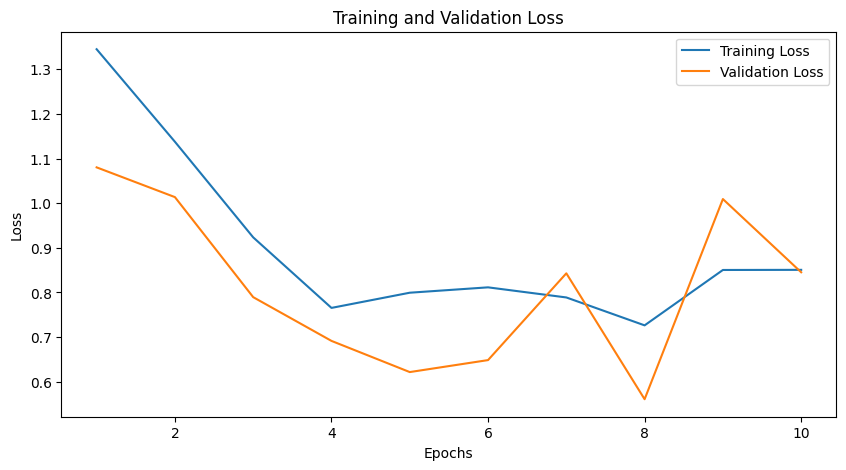

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model2.state_dict(), 'vgg16_model.pth')

**Fourth combination**

In [ ]:
from torchvision.models import vgg16
model3 = vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model3.classifier[6] = nn.Sequential(
    nn.Linear(4096,10),
    nn.ReLU(True),
    nn.Dropout(0.7),
    nn.Linear(10,7)
)

In [ ]:
model3.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.00001, weight_decay=0.1)

In [ ]:
num_epochs = 10
train_losses3 = []
val_losses3 = []
test_losses3 = []

for epoch in range(num_epochs):
    start_time = time.time()

    model3.train()
    running_loss3 = 0.0
    correct3 = 0
    total3 = 0

    for inputs, labels in train_loader_vgg:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer3.zero_grad()
        outputs = model3(inputs)

        loss = criterion3(outputs, labels)
        loss.backward()
        optimizer3.step()
        running_loss3 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total3 += labels.size(0)
        correct3 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy3 = 100 * correct3 / total3
    train_loss3 = running_loss3 / len(train_loader_vgg)
    train_losses3.append(train_loss3)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss3:.4f}, Train Accuracy: {train_accuracy3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    model3.eval()
    running_loss3 = 0.0
    correct3 = 0
    total3 = 0

    with torch.no_grad():
      for inputs, labels in val_loader_vgg:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model3(inputs)
        loss = criterion3(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total3 += labels.size(0)
        correct3 += (predicted == labels).sum().item()

        running_loss3 += loss

    val_loss3 = running_loss3 / len(val_loader_vgg)
    val_losses3.append(val_loss3)
    val_accuracy3 = 100 * correct3 / total3

    print(f"Epoch {epoch+1}, Val Loss: {val_loss3:.4f}, Val Accuracy: {val_accuracy3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

model3.eval()
running_loss3 = 0.0
correct3 = 0
total3 = 0

with torch.no_grad():
    for inputs, labels in test_loader_vgg:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model3(inputs)
        loss = criterion3(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total3 += labels.size(0)
        correct3 += (predicted == labels).sum().item()

        running_loss3 += loss

test_loss3 = running_loss3 / len(test_loader_vgg)
test_losses3.append(test_loss3)
test_accuracy3 = 100 * correct3 / total3

print(f"Epoch {epoch+1}, Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses3, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **ResNet**

**First combination**

In [ ]:
train_loader_resnet = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_resnet = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader_resnet = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torchvision.models import resnet50

resnet_model = resnet50(pretrained=True)

resnet_model.fc = nn.Sequential(
    nn.Linear(2048, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses_resnet = []
val_losses_resnet = []
test_losses_resnet = []

for epoch in range(num_epochs):
    start_time = time.time()

    resnet_model.train()
    running_loss_resnet = 0.0
    correct_resnet = 0
    total_resnet = 0

    for inputs, labels in train_loader_resnet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        resnet_optimizer.zero_grad()
        outputs = resnet_model(inputs)

        loss = resnet_criterion(outputs, labels)
        loss.backward()
        resnet_optimizer.step()
        running_loss_resnet += loss.item()

        _, predicted = torch.max(outputs.data, 1)

        total_resnet += labels.size(0)
        correct_resnet += (predicted == labels).sum().item()

    end_time = time.time()

    elapsed_time = end_time - start_time

    train_accuracy_resnet = 100 * correct_resnet / total_resnet
    train_loss_resnet = running_loss_resnet / len(train_loader_resnet)

    train_losses_resnet.append(train_loss_resnet)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_resnet:.4f}, Train Accuracy: {train_accuracy_resnet:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    resnet_model.eval()
    running_loss_resnet = 0.0
    correct_resnet = 0
    total_resnet = 0

    with torch.no_grad():
        for inputs, labels in val_loader_resnet:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet_model(inputs)
            loss = resnet_criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_resnet += labels.size(0)
            correct_resnet += (predicted == labels).sum().item()

            running_loss_resnet += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_resnet = running_loss_resnet / len(val_loader_resnet)
    val_losses_resnet.append(val_loss_resnet)
    val_accuracy_resnet = 100 * correct_resnet / total_resnet

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_resnet:.4f}, Val Accuracy: {val_accuracy_resnet:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

resnet_model.eval()
running_loss_resnet = 0.0
correct_resnet = 0
total_resnet = 0

with torch.no_grad():
    for inputs, labels in test_loader_resnet:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet_model(inputs)
        loss = resnet_criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_resnet += labels.size(0)
        correct_resnet += (predicted == labels).sum().item()

        running_loss_resnet += loss

end_time = time.time()
elapsed_time = end_time - start_time
test_loss_resnet = running_loss_resnet / len(test_loader_resnet)
test_losses_resnet.append(test_loss_resnet)
test_accuracy_resnet = 100 * correct_resnet / total_resnet

print(f"Epoch {epoch+1}, Test Loss: {test_loss_resnet:.4f}, Test Accuracy: {test_accuracy_resnet:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_resnet, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_resnet, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Second combination**

In [ ]:
resnet_model1 = resnet50(pretrained=True)

resnet_model1.fc = nn.Sequential(
    nn.Linear(2048, 10),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(10, 7)
)

resnet_model1.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_criterion1 = nn.CrossEntropyLoss()
resnet_optimizer1 = torch.optim.Adam(resnet_model1.parameters(), lr=0.0001, weight_decay=0.0001)

In [ ]:
num_epochs = 10
train_losses_resnet1 = []
val_losses_resnet1 = []
test_losses_resnet1 = []

for epoch in range(num_epochs):
    start_time = time.time()

    resnet_model1.train()
    running_loss_resnet1 = 0.0
    correct_resnet1 = 0
    total_resnet1 = 0

    for inputs, labels in train_loader_resnet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        resnet_optimizer1.zero_grad()
        outputs = resnet_model1(inputs)

        loss = resnet_criterion1(outputs, labels)
        loss.backward()

        resnet_optimizer1.step()
        running_loss_resnet1 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_resnet1 += labels.size(0)

        correct_resnet1 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy_resnet1 = 100 * correct_resnet1 / total_resnet1
    train_loss_resnet1 = running_loss_resnet1 / len(train_loader_resnet)

    train_losses_resnet1.append(train_loss_resnet1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_resnet1:.4f}, Train Accuracy: {train_accuracy_resnet1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    resnet_model1.eval()
    running_loss_resnet1 = 0.0
    correct_resnet1 = 0
    total_resnet1 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_resnet:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet_model1(inputs)
            loss = resnet_criterion1(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_resnet1 += labels.size(0)
            correct_resnet1 += (predicted == labels).sum().item()
            running_loss_resnet1 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_resnet1 = running_loss_resnet1 / len(val_loader_resnet)
    val_losses_resnet1.append(val_loss_resnet1)
    val_accuracy_resnet1 = 100 * correct_resnet1 / total_resnet1
    print(f"Epoch {epoch+1}, Val Loss: {val_loss_resnet1:.4f}, Val Accuracy: {val_accuracy_resnet1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

Epoch 1, Train Loss: 0.9604, Train Accuracy: 64.73%
Elapsed Time: 44.94 seconds
--------------------------------------------------

Epoch 1, Val Loss: 0.6405, Val Accuracy: 77.65%
Elapsed Time: 8.75 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.6194, Train Accuracy: 73.19%
Elapsed Time: 42.57 seconds
--------------------------------------------------

Epoch 2, Val Loss: 0.5738, Val Accuracy: 78.71%
Elapsed Time: 8.79 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.5593, Train Accuracy: 74.59%
Elapsed Time: 42.69 seconds
--------------------------------------------------

Epoch 3, Val Loss: 0.6552, Val Accuracy: 74.89%
Elapsed Time: 8.58 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.5291, Train Accuracy: 77.95%
Elapsed Time: 44.38 seconds
--------------------------------------------------

Epoch 4, Val Loss: 0.5108, Val Accuracy: 86.76%
Elapsed Time: 8.54 seconds
----------------

In [ ]:
start_time = time.time()

resnet_model1.eval()
running_loss_resnet1 = 0.0
correct_resnet1 = 0
total_resnet1 = 0

all_labels_resnet1 = []
all_predictions_resnet1 = []

with torch.no_grad():
    for inputs, labels in test_loader_resnet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet_model1(inputs)
        loss = resnet_criterion1(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_resnet1 += labels.size(0)
        correct_resnet1 += (predicted == labels).sum().item()
        running_loss_resnet1 += loss

        all_labels_resnet1.extend(labels.cpu().numpy())
        all_predictions_resnet1.extend(predicted.cpu().numpy())

end_time = time.time()
elapsed_time = end_time - start_time
test_loss_resnet1 = running_loss_resnet1 / len(test_loader_resnet)
test_losses_resnet1.append(test_loss_resnet1)
test_accuracy_resnet1 = 100 * correct_resnet1 / total_resnet1

print(f"Epoch {epoch+1}, Test Loss: {test_loss_resnet1:.4f}, Test Accuracy: {test_accuracy_resnet1:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

conf_matrix_resnet1 = confusion_matrix(all_labels_resnet1, all_predictions_resnet1)
print("Confusion Matrix:")
print(conf_matrix_resnet1)

Epoch 10, Test Loss: 0.3541, Test Accuracy: 89.71%
Elapsed Time: 6.77 seconds
--------------------------------------------------

Confusion Matrix:
[[ 66   0   1   0   5   0   2]
 [  0  43   4  11   0   0   5]
 [  5   0 129   1   1   2   0]
 [  2   0   1 100   0   4   3]
 [  2   0   0   0 122   4  10]
 [  0   0   1   1   6 122   0]
 [  0   0   0   5   3   0 107]]


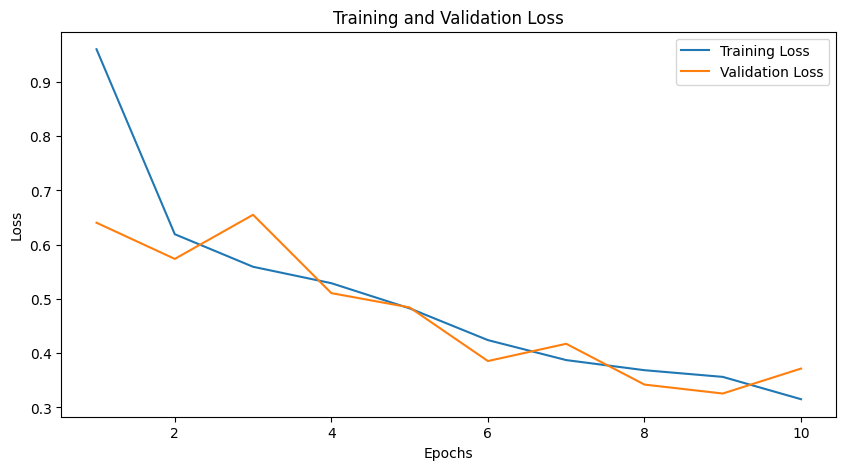

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_resnet1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_resnet1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(resnet_model1.state_dict(), 'resnet_model1.pth')

**Third combination**

In [ ]:
train_loader_resnet1 = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_resnet1 = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader_resnet1 = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
resnet_model2 = resnet50(pretrained=True)

resnet_model2.fc = nn.Sequential(
    nn.Linear(2048, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

resnet_model2.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 65.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_criterion2 = nn.CrossEntropyLoss()
resnet_optimizer2 = torch.optim.Adam(resnet_model2.parameters(), lr=0.0001, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses_resnet2 = []
val_losses_resnet2 = []
test_losses_resnet2 = []

for epoch in range(num_epochs):
    start_time = time.time()

    resnet_model2.train()
    running_loss_resnet2 = 0.0
    correct_resnet2 = 0
    total_resnet2 = 0

    for inputs, labels in train_loader_resnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        resnet_optimizer2.zero_grad()
        outputs = resnet_model2(inputs)

        loss = resnet_criterion2(outputs, labels)
        loss.backward()
        resnet_optimizer2.step()
        running_loss_resnet2 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_resnet2 += labels.size(0)
        correct_resnet2 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy_resnet2 = 100 * correct_resnet2 / total_resnet2
    train_loss_resnet2 = running_loss_resnet2 / len(train_loader_resnet1)
    train_losses_resnet2.append(train_loss_resnet2)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_resnet2:.4f}, Train Accuracy: {train_accuracy_resnet2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    resnet_model2.eval()
    running_loss_resnet2 = 0.0
    correct_resnet2 = 0
    total_resnet2 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_resnet1:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = resnet_model2(inputs)
            loss = resnet_criterion2(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_resnet2 += labels.size(0)
            correct_resnet2 += (predicted == labels).sum().item()
            running_loss_resnet2 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_resnet2 = running_loss_resnet2 / len(val_loader_resnet1)
    val_losses_resnet2.append(val_loss_resnet2)
    val_accuracy_resnet2 = 100 * correct_resnet2 / total_resnet2

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_resnet2:.4f}, Val Accuracy: {val_accuracy_resnet2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

resnet_model2.eval()
running_loss_resnet2 = 0.0
correct_resnet2 = 0
total_resnet2 = 0

with torch.no_grad():
    for inputs, labels in test_loader_resnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet_model2(inputs)
        loss = resnet_criterion2(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_resnet2 += labels.size(0)
        correct_resnet2 += (predicted == labels).sum().item()
        running_loss_resnet2 += loss

end_time = time.time()
elapsed_time = end_time - start_time
test_loss_resnet2 = running_loss_resnet2 / len(test_loader_resnet1)
test_losses_resnet2.append(test_loss_resnet2)
test_accuracy_resnet2 = 100 * correct_resnet2 / total_resnet2

print(f"Epoch {epoch+1}, Test Loss: {test_loss_resnet2:.4f}, Test Accuracy: {test_accuracy_resnet2:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_resnet2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_resnet2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Fourth combination**

In [ ]:
resnet_model3 = resnet50(pretrained=True)

resnet_model3.fc = nn.Sequential(
    nn.Linear(2048, 10),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(10, 7)
)

resnet_model3.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet_criterion3 = nn.CrossEntropyLoss()
resnet_optimizer3 = torch.optim.Adam(resnet_model3.parameters(), lr=0.01, weight_decay=0.1)

In [ ]:
num_epochs = 10
train_losses_resnet3 = []
val_losses_resnet3 = []
test_losses_resnet3 = []

for epoch in range(num_epochs):
    start_time = time.time()

    resnet_model3.train()
    running_loss_resnet3 = 0.0
    correct_resnet3 = 0
    total_resnet3 = 0

    for inputs, labels in train_loader_resnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)
        resnet_optimizer3.zero_grad()
        outputs = resnet_model3(inputs)

        loss = resnet_criterion3(outputs, labels)

        loss.backward()
        resnet_optimizer3.step()
        running_loss_resnet3 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_resnet3 += labels.size(0)
        correct_resnet3 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy_resnet3 = 100 * correct_resnet3 / total_resnet3
    train_loss_resnet3 = running_loss_resnet3 / len(train_loader_resnet1)

    train_losses_resnet3.append(train_loss_resnet3)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_resnet3:.4f}, Train Accuracy: {train_accuracy_resnet3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    resnet_model3.eval()
    running_loss_resnet3 = 0.0
    correct_resnet3 = 0
    total_resnet3 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_resnet1:
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = resnet_model3(inputs)
          loss = resnet_criterion3(outputs, labels).item()
          _, predicted = torch.max(outputs, 1)
          total_resnet3 += labels.size(0)
          correct_resnet3 += (predicted == labels).sum().item()
          running_loss_resnet3 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_resnet3 = running_loss_resnet3 / len(val_loader_resnet1)
    val_losses_resnet3.append(val_loss_resnet3)
    val_accuracy_resnet3 = 100 * correct_resnet3 / total_resnet3

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_resnet3:.4f}, Val Accuracy: {val_accuracy_resnet3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

resnet_model3.eval()
running_loss_resnet3 = 0.0
correct_resnet3 = 0
total_resnet3 = 0

with torch.no_grad():
    for inputs, labels in test_loader_resnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet_model3(inputs)
        loss = resnet_criterion3(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_resnet3 += labels.size(0)
        correct_resnet3 += (predicted == labels).sum().item()


        running_loss_resnet3 += loss

end_time = time.time()
elapsed_time = end_time - start_time
test_loss_resnet3 = running_loss_resnet3 / len(test_loader_resnet1)
test_losses_resnet3.append(test_loss_resnet3)

test_accuracy_resnet3 = 100 * correct_resnet3 / total_resnet3

print(f"Epoch {epoch+1}, Test Loss: {test_loss_resnet3:.4f}, Test Accuracy: {test_accuracy_resnet3:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_resnet3, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_resnet3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **AlexNet**

In [ ]:
transform_alexnet = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset_alexnet = datasets.ImageFolder(os.path.join(image_data, 'train'), transform=transform_alexnet)
val_dataset_alexnet = datasets.ImageFolder(os.path.join(image_data, 'val'), transform=transform_alexnet)
test_dataset_alexnet = datasets.ImageFolder(os.path.join(image_data, 'test'), transform=transform_alexnet)


In [ ]:
train_loader_alexnet = torch.utils.data.DataLoader(train_dataset_alexnet, batch_size=32, shuffle=True)
val_loader_alexnet = torch.utils.data.DataLoader(val_dataset_alexnet, batch_size=32, shuffle=False)
test_loader_alexnet = torch.utils.data.DataLoader(test_dataset_alexnet, batch_size=32, shuffle=False)

In [ ]:
from torchvision.models import alexnet

alexnet_model = alexnet(pretrained=True)

alexnet_model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

alexnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 161MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_criterion = nn.CrossEntropyLoss()
alexnet_optimizer = torch.optim.Adam(alexnet_model.parameters(), lr=0.001, weight_decay=0.001)

**First combination**

In [ ]:
num_epochs = 10
train_losses_alexnet = []
val_losses_alexnet = []
test_losses_alexnet = []

for epoch in range(num_epochs):
    start_time = time.time()

    alexnet_model.train()
    running_loss_alexnet = 0.0
    correct_alexnet = 0
    total_alexnet = 0

    for inputs, labels in train_loader_alexnet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        alexnet_optimizer.zero_grad()
        outputs = alexnet_model(inputs)

        loss = alexnet_criterion(outputs, labels)
        loss.backward()
        alexnet_optimizer.step()
        running_loss_alexnet += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_alexnet += labels.size(0)
        correct_alexnet += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy_alexnet = 100 * correct_alexnet / total_alexnet
    train_loss_alexnet = running_loss_alexnet / len(train_loader_alexnet)

    train_losses_alexnet.append(train_loss_alexnet)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_alexnet:.4f}, Train Accuracy: {train_accuracy_alexnet:.2f}%")

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    alexnet_model.eval()
    running_loss_alexnet = 0.0
    correct_alexnet = 0
    total_alexnet = 0

    with torch.no_grad():
        for inputs, labels in val_loader_alexnet:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = alexnet_model(inputs)
            loss = alexnet_criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_alexnet += labels.size(0)
            correct_alexnet += (predicted == labels).sum().item()
            running_loss_alexnet += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_alexnet = running_loss_alexnet / len(val_loader_alexnet)
    val_losses_alexnet.append(val_loss_alexnet)
    val_accuracy_alexnet = 100 * correct_alexnet / total_alexnet
    print(f"Epoch {epoch+1}, Val Loss: {val_loss_alexnet:.4f}, Val Accuracy: {val_accuracy_alexnet:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

alexnet_model.eval()
running_loss_alexnet = 0.0
correct_alexnet = 0
total_alexnet = 0

with torch.no_grad():
    for inputs, labels in test_loader_alexnet:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexnet_model(inputs)
        loss = alexnet_criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_alexnet += labels.size(0)
        correct_alexnet += (predicted == labels).sum().item()

        running_loss_alexnet += loss

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_alexnet = running_loss_alexnet / len(test_loader_alexnet)
test_losses_alexnet.append(test_loss_alexnet)
test_accuracy_alexnet = 100 * correct_alexnet / total_alexnet
print(f"Epoch {epoch+1}, Test Loss: {test_loss_alexnet:.4f}, Test Accuracy: {test_accuracy_alexnet:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_alexnet, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_alexnet, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Scond combination**

In [ ]:
alexnet_model1 = alexnet(pretrained=True)

alexnet_model1.classifier[6] = nn.Sequential(
    nn.Linear(4096, 10),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(10, 7)
)

alexnet_model1.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_criterion1 = nn.CrossEntropyLoss()
alexnet_optimizer1 = torch.optim.Adam(alexnet_model1.parameters(), lr=0.0001, weight_decay=0.0001)

In [ ]:
num_epochs = 10
train_losses_alexnet1 = []
val_losses_alexnet1 = []
test_losses_alexnet1 = []

for epoch in range(num_epochs):
    start_time = time.time()

    alexnet_model1.train()
    running_loss_alexnet1 = 0.0
    correct_alexnet1 = 0
    total_alexnet1 = 0

    for inputs, labels in train_loader_alexnet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        alexnet_optimizer1.zero_grad()
        outputs = alexnet_model1(inputs)
        loss = alexnet_criterion1(outputs, labels)

        loss.backward()

        alexnet_optimizer1.step()
        running_loss_alexnet1 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_alexnet1 += labels.size(0)
        correct_alexnet1 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_accuracy_alexnet1 = 100 * correct_alexnet1 / total_alexnet1
    train_loss_alexnet1 = running_loss_alexnet1 / len(train_loader_alexnet)

    train_losses_alexnet1.append(train_loss_alexnet1)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_alexnet1:.4f}, Train Accuracy: {train_accuracy_alexnet1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()
    alexnet_model1.eval()
    running_loss_alexnet1 = 0.0
    correct_alexnet1 = 0
    total_alexnet1 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_alexnet:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = alexnet_model1(inputs)
            loss = alexnet_criterion1(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_alexnet1 += labels.size(0)
            correct_alexnet1 += (predicted == labels).sum().item()


            running_loss_alexnet1 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_alexnet1 = running_loss_alexnet1 / len(val_loader_alexnet)
    val_losses_alexnet1.append(val_loss_alexnet1)
    val_accuracy_alexnet1 = 100 * correct_alexnet1 / total_alexnet1
    print(f"Epoch {epoch+1}, Val Loss: {val_loss_alexnet1:.4f}, Val Accuracy: {val_accuracy_alexnet1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

Epoch 1, Train Loss: 0.9625, Train Accuracy: 63.33%
Elapsed Time: 24.53 seconds
--------------------------------------------------

Epoch 1, Val Loss: 0.5530, Val Accuracy: 84.32%
Elapsed Time: 7.11 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.5164, Train Accuracy: 80.50%
Elapsed Time: 22.31 seconds
--------------------------------------------------

Epoch 2, Val Loss: 0.5216, Val Accuracy: 86.12%
Elapsed Time: 6.88 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.4072, Train Accuracy: 84.75%
Elapsed Time: 23.01 seconds
--------------------------------------------------

Epoch 3, Val Loss: 0.5057, Val Accuracy: 86.33%
Elapsed Time: 6.68 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.3071, Train Accuracy: 88.22%
Elapsed Time: 22.72 seconds
--------------------------------------------------

Epoch 4, Val Loss: 0.5116, Val Accuracy: 87.82%
Elapsed Time: 6.13 seconds
----------------

In [ ]:
start_time = time.time()

alexnet_model1.eval()
running_loss_alexnet1 = 0.0
correct_alexnet1 = 0
total_alexnet1 = 0

all_labels_alexnet1 = []
all_predictions_alexnet1 = []

with torch.no_grad():
    for inputs, labels in test_loader_alexnet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = alexnet_model1(inputs)
        loss = alexnet_criterion1(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_alexnet1 += labels.size(0)
        correct_alexnet1 += (predicted == labels).sum().item()

        running_loss_alexnet1 += loss

        all_labels_alexnet1.extend(labels.cpu().numpy())
        all_predictions_alexnet1.extend(predicted.cpu().numpy())

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_alexnet1 = running_loss_alexnet1 / len(test_loader_alexnet)
test_losses_alexnet1.append(test_loss_alexnet1)

test_accuracy_alexnet1 = 100 * correct_alexnet1 / total_alexnet1

print(f"Epoch {epoch+1}, Test Loss: {test_loss_alexnet1:.4f}, Test Accuracy: {test_accuracy_alexnet1:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

conf_matrix_alexnet1 = confusion_matrix(all_labels_alexnet1, all_predictions_alexnet1)
print("Confusion Matrix:")
print(conf_matrix_alexnet1)

Epoch 10, Test Loss: 1.0771, Test Accuracy: 80.99%
Elapsed Time: 5.03 seconds
--------------------------------------------------

Confusion Matrix:
[[ 64   4   0   2   3   0   1]
 [  1  55   2   5   0   0   0]
 [  4   1 127   1   3   1   1]
 [  2   7   3  96   1   0   1]
 [ 12  17   0  12  84   3  10]
 [  0   3   4   3   1 117   2]
 [  8  17   0   8   3   0  79]]


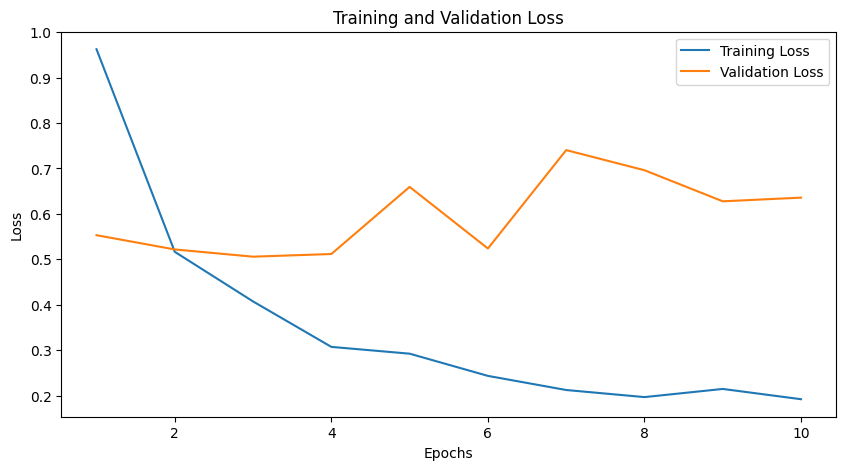

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_alexnet1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_alexnet1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(alexnet_model1.state_dict(), 'alexnet_model1.pth')

**Third combination**

In [ ]:
train_loader_alexnet1 = torch.utils.data.DataLoader(train_dataset_alexnet, batch_size=16, shuffle=True)
val_loader_alexnet1 = torch.utils.data.DataLoader(val_dataset_alexnet, batch_size=16, shuffle=False)
test_loader_alexnet1 = torch.utils.data.DataLoader(test_dataset_alexnet, batch_size=16, shuffle=False)

In [ ]:
alexnet_model2 = alexnet(pretrained=True)

alexnet_model2.classifier[6] = nn.Sequential(
    nn.Linear(4096, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

alexnet_model2.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_criterion2 = nn.CrossEntropyLoss()
alexnet_optimizer2 = torch.optim.Adam(alexnet_model2.parameters(), lr=0.0001, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses_alexnet2 = []
val_losses_alexnet2 = []
test_losses_alexnet2 = []

for epoch in range(num_epochs):
    start_time = time.time()

    alexnet_model2.train()
    running_loss_alexnet2 = 0.0
    correct_alexnet2 = 0
    total_alexnet2 = 0

    for inputs, labels in train_loader_alexnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        alexnet_optimizer2.zero_grad()

        outputs = alexnet_model2(inputs)
        loss = alexnet_criterion2(outputs, labels)

        loss.backward()
        alexnet_optimizer2.step()
        running_loss_alexnet2 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_alexnet2 += labels.size(0)
        correct_alexnet2 += (predicted == labels).sum().item()

    end_time = time.time()

    elapsed_time = end_time - start_time
    train_accuracy_alexnet2 = 100 * correct_alexnet2 / total_alexnet2
    train_loss_alexnet2 = running_loss_alexnet2 / len(train_loader_alexnet1)

    train_losses_alexnet2.append(train_loss_alexnet2)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_alexnet2:.4f}, Train Accuracy: {train_accuracy_alexnet2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    alexnet_model2.eval()

    running_loss_alexnet2 = 0.0
    correct_alexnet2 = 0
    total_alexnet2 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_alexnet1:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = alexnet_model2(inputs)
            loss = alexnet_criterion2(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_alexnet2 += labels.size(0)
            correct_alexnet2 += (predicted == labels).sum().item()
            running_loss_alexnet2 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_alexnet2 = running_loss_alexnet2 / len(val_loader_alexnet1)
    val_losses_alexnet2.append(val_loss_alexnet2)
    val_accuracy_alexnet2 = 100 * correct_alexnet2 / total_alexnet2

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_alexnet2:.4f}, Val Accuracy: {val_accuracy_alexnet2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

alexnet_model2.eval()

running_loss_alexnet2 = 0.0
correct_alexnet2 = 0
total_alexnet2 = 0

with torch.no_grad():
    for inputs, labels in test_loader_alexnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexnet_model2(inputs)

        loss = alexnet_criterion2(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_alexnet2 += labels.size(0)
        correct_alexnet2 += (predicted == labels).sum().item()
        running_loss_alexnet2 += loss

end_time = time.time()
elapsed_time = end_time - start_time
test_loss_alexnet2 = running_loss_alexnet2 / len(test_loader_alexnet1)
test_losses_alexnet2.append(test_loss_alexnet2)
test_accuracy_alexnet2 = 100 * correct_alexnet2 / total_alexnet2

print(f"Epoch {epoch+1}, Test Loss: {test_loss_alexnet2:.4f}, Test Accuracy: {test_accuracy_alexnet2:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_alexnet2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_alexnet2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Fourth combination**

In [ ]:
alexnet_model3 = alexnet(pretrained=True)

alexnet_model3.classifier[6] = nn.Sequential(
    nn.Linear(4096, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

alexnet_model3.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alexnet_criterion3 = nn.CrossEntropyLoss()
alexnet_optimizer3 = torch.optim.Adam(alexnet_model3.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
num_epochs = 10
train_losses_alexnet3 = []
val_losses_alexnet3 = []
test_losses_alexnet3 = []

for epoch in range(num_epochs):
    start_time = time.time()

    alexnet_model3.train()
    running_loss_alexnet3 = 0.0
    correct_alexnet3 = 0
    total_alexnet3 = 0

    for inputs, labels in train_loader_alexnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        alexnet_optimizer3.zero_grad()

        outputs = alexnet_model3(inputs)
        loss = alexnet_criterion3(outputs, labels)

        loss.backward()
        alexnet_optimizer3.step()
        running_loss_alexnet3 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_alexnet3 += labels.size(0)
        correct_alexnet3 += (predicted == labels).sum().item()

    end_time = time.time()

    elapsed_time = end_time - start_time
    train_accuracy_alexnet3 = 100 * correct_alexnet3 / total_alexnet3
    train_loss_alexnet3 = running_loss_alexnet3 / len(train_loader_alexnet1)
    train_losses_alexnet3.append(train_loss_alexnet3)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_alexnet3:.4f}, Train Accuracy: {train_accuracy_alexnet3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()
    alexnet_model3.eval()

    running_loss_alexnet3 = 0.0
    correct_alexnet3 = 0
    total_alexnet3 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_alexnet1:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = alexnet_model3(inputs)
            loss = alexnet_criterion3(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_alexnet3 += labels.size(0)
            correct_alexnet3 += (predicted == labels).sum().item()
            running_loss_alexnet3 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_alexnet3 = running_loss_alexnet3 / len(val_loader_alexnet1)
    val_losses_alexnet3.append(val_loss_alexnet3)
    val_accuracy_alexnet3 = 100 * correct_alexnet3 / total_alexnet3

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_alexnet3:.4f}, Val Accuracy: {val_accuracy_alexnet3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

alexnet_model3.eval()
running_loss_alexnet3 = 0.0
correct_alexnet3 = 0
total_alexnet3 = 0

with torch.no_grad():
    for inputs, labels in test_loader_alexnet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = alexnet_model3(inputs)
        loss = alexnet_criterion3(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_alexnet3 += labels.size(0)
        correct_alexnet3 += (predicted == labels).sum().item()
        running_loss_alexnet3 += loss

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_alexnet3 = running_loss_alexnet3 / len(test_loader_alexnet1)
test_losses_alexnet3.append(test_loss_alexnet3)
test_accuracy_alexnet3 = 100 * correct_alexnet3 / total_alexnet3

print(f"Epoch {epoch+1}, Test Loss: {test_loss_alexnet3:.4f}, Test Accuracy: {test_accuracy_alexnet3:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

Epoch 1, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.55 seconds
--------------------------------------------------

Epoch 2, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.83 seconds
--------------------------------------------------

Epoch 3, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.42 seconds
--------------------------------------------------

Epoch 4, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 6.18 seconds
--------------------------------------------------

Epoch 5, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.43 seconds
--------------------------------------------------

Epoch 6, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.92 seconds
--------------------------------------------------

Epoch 7, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.56 seconds
--------------------------------------------------

Epoch 8, Test Loss: 1.9220, Test Accuracy: 17.97%
Elapsed Time: 5.21 seconds
--------------------

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_alexnet3, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_alexnet3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# **DenseNet**

In [ ]:
train_loader_densenet = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_densenet = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader_densenet = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

**First combination**

In [ ]:
from torchvision.models import densenet121

densenet_model = densenet121(pretrained=True)

densenet_model.classifier = nn.Sequential(
    nn.Linear(1024, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

densenet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 55.7MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet_criterion = nn.CrossEntropyLoss()
densenet_optimizer = torch.optim.Adam(densenet_model.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses_densenet = []
val_losses_densenet = []
test_losses_densenet = []

for  epoch in range(num_epochs):
    start_time = time.time()

    densenet_model.train()
    running_loss_densenet = 0.0
    correct_densenet = 0
    total_densenet = 0

    for inputs, labels in train_loader_densenet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        densenet_optimizer.zero_grad()
        outputs = densenet_model(inputs)
        loss = densenet_criterion(outputs, labels)

        loss.backward()
        densenet_optimizer.step()

        running_loss_densenet += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_densenet += labels.size(0)
        correct_densenet += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    train_accuracy_densenet = 100 * correct_densenet / total_densenet
    train_loss_densenet = running_loss_densenet / len(train_loader_densenet)

    train_losses_densenet.append(train_loss_densenet)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_densenet:.4f}, Train Accuracy: {train_accuracy_densenet:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    densenet_model.eval()
    running_loss_densenet = 0.0
    correct_densenet = 0
    total_densenet = 0

    with torch.no_grad():
        for inputs, labels in val_loader_densenet:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = densenet_model(inputs)

            loss = densenet_criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_densenet += labels.size(0)
            correct_densenet += (predicted == labels).sum().item()
            running_loss_densenet += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_densenet = running_loss_densenet / len(val_loader_densenet)

    val_losses_densenet.append(val_loss_densenet)
    val_accuracy_densenet = 100 * correct_densenet / total_densenet
    print(f"Epoch {epoch+1}, Val Loss: {val_loss_densenet:.4f}, Val Accuracy: {val_accuracy_densenet:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

densenet_model.eval()
running_loss_densenet = 0.0
correct_densenet = 0
total_densenet = 0

with torch.no_grad():
    for inputs, labels in test_loader_densenet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = densenet_model(inputs)

        loss = densenet_criterion(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_densenet += labels.size(0)
        correct_densenet += (predicted == labels).sum().item()
        running_loss_densenet += loss

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_densenet = running_loss_densenet / len(test_loader_densenet)
test_losses_densenet.append(test_loss_densenet)
test_accuracy_densenet = 100 * correct_densenet / total_densenet

print(f"Epoch {epoch+1}, Test Loss: {test_loss_densenet:.4f}, Test Accuracy: {test_accuracy_densenet:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_densenet, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_densenet, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses_densenet, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

**Second combination**

In [ ]:
densenet_model1 = densenet121(pretrained=True)

densenet_model1.classifier = nn.Sequential(
    nn.Linear(1024, 10),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(10, 7)
)

densenet_model1.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet_criterion1 = nn.CrossEntropyLoss()
densenet_optimizer1 = torch.optim.Adam(densenet_model1.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
num_epochs = 10
train_losses_densenet1 = []
val_losses_densenet1 = []
test_losses_densenet1 = []

for epoch in range(num_epochs):
    start_time = time.time()

    densenet_model1.train()
    running_loss_densenet1 = 0.0
    correct_densenet1 = 0
    total_densenet1 = 0

    for inputs, labels in train_loader_densenet:
        inputs = inputs.to(device)
        labels = labels.to(device)

        densenet_optimizer1.zero_grad()
        outputs = densenet_model1(inputs)
        loss = densenet_criterion1(outputs, labels)

        loss.backward()
        densenet_optimizer1.step()

        running_loss_densenet1 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_densenet1 += labels.size(0)
        correct_densenet1 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    train_accuracy_densenet1 = 100 * correct_densenet1 / total_densenet1
    train_loss_densenet1 = running_loss_densenet1 / len(train_loader_densenet)
    train_losses_densenet1.append(train_loss_densenet1)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_densenet1:.4f}, Train Accuracy: {train_accuracy_densenet1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    densenet_model1.eval()
    running_loss_densenet1 = 0.0
    correct_densenet1 = 0
    total_densenet1 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_densenet:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = densenet_model1(inputs)
            loss = densenet_criterion1(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_densenet1 += labels.size(0)
            correct_densenet1 += (predicted == labels).sum().item()
            running_loss_densenet1 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_densenet1 = running_loss_densenet1 / len(val_loader_densenet)
    val_losses_densenet1.append(val_loss_densenet1)
    val_accuracy_densenet1 = 100 * correct_densenet1 / total_densenet1

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_densenet1:.4f}, Val Accuracy: {val_accuracy_densenet1:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

densenet_model1.eval()
running_loss_densenet1 = 0.0
correct_densenet1 = 0
total_densenet1 = 0

with torch.no_grad():
    for inputs, labels in test_loader_densenet:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = densenet_model1(inputs)
        loss = densenet_criterion1(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_densenet1 += labels.size(0)
        correct_densenet1 += (predicted == labels).sum().item()
        running_loss_densenet1 += loss

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_densenet1 = running_loss_densenet1 / len(test_loader_densenet)
test_losses_densenet1.append(test_loss_densenet1)
test_accuracy_densenet1 = 100 * correct_densenet1 / total_densenet1

print(f"Epoch {epoch+1}, Test Loss: {test_loss_densenet1:.4f}, Test Accuracy: {test_accuracy_densenet1:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_densenet1, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_densenet1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Third combination**

In [ ]:
train_loader_densenet1 = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_densenet1 = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader_densenet1 = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
densenet_model2 = densenet121(pretrained=True)

densenet_model2.classifier = nn.Sequential(
    nn.Linear(1024, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

densenet_model2.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 76.3MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet_criterion2 = nn.CrossEntropyLoss()
densenet_optimizer2 = torch.optim.Adam(densenet_model2.parameters(), lr=0.0001, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses_densenet2 = []
val_losses_densenet2 = []
test_losses_densenet2 = []

for epoch in range(num_epochs):
    start_time = time.time()

    densenet_model2.train()
    running_loss_densenet2 = 0.0
    correct_densenet2 = 0
    total_densenet2 = 0

    for inputs, labels in train_loader_densenet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        densenet_optimizer2.zero_grad()
        outputs = densenet_model2(inputs)
        loss = densenet_criterion2(outputs, labels)

        loss.backward()
        densenet_optimizer2.step()

        running_loss_densenet2 += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_densenet2 += labels.size(0)
        correct_densenet2 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    train_accuracy_densenet2 = 100 * correct_densenet2 / total_densenet2
    train_loss_densenet2 = running_loss_densenet2 / len(train_loader_densenet1)
    train_losses_densenet2.append(train_loss_densenet2)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_densenet2:.4f}, Train Accuracy: {train_accuracy_densenet2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    densenet_model2.eval()
    running_loss_densenet2 = 0.0
    correct_densenet2 = 0
    total_densenet2 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_densenet1:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = densenet_model2(inputs)
            loss = densenet_criterion2(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_densenet2 += labels.size(0)
            correct_densenet2 += (predicted == labels).sum().item()

            running_loss_densenet2 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_densenet2 = running_loss_densenet2 / len(val_loader_densenet1)
    val_losses_densenet2.append(val_loss_densenet2)
    val_accuracy_densenet2 = 100 * correct_densenet2 / total_densenet2

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_densenet2:.4f}, Val Accuracy: {val_accuracy_densenet2:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

Epoch 1, Train Loss: 1.3554, Train Accuracy: 44.31%
Elapsed Time: 55.95 seconds
--------------------------------------------------

Epoch 1, Val Loss: 0.7183, Val Accuracy: 88.24%
Elapsed Time: 12.07 seconds
--------------------------------------------------

Epoch 2, Train Loss: 0.9188, Train Accuracy: 64.40%
Elapsed Time: 65.53 seconds
--------------------------------------------------

Epoch 2, Val Loss: 0.5329, Val Accuracy: 91.74%
Elapsed Time: 12.37 seconds
--------------------------------------------------

Epoch 3, Train Loss: 0.8139, Train Accuracy: 67.43%
Elapsed Time: 57.83 seconds
--------------------------------------------------

Epoch 3, Val Loss: 0.4033, Val Accuracy: 93.22%
Elapsed Time: 8.74 seconds
--------------------------------------------------

Epoch 4, Train Loss: 0.7363, Train Accuracy: 70.35%
Elapsed Time: 44.53 seconds
--------------------------------------------------

Epoch 4, Val Loss: 0.3640, Val Accuracy: 92.48%
Elapsed Time: 8.89 seconds
--------------

In [ ]:
start_time = time.time()

densenet_model2.eval()
running_loss_densenet2 = 0.0
correct_densenet2 = 0
total_densenet2 = 0

with torch.no_grad():
    for inputs, labels in test_loader_densenet1:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = densenet_model2(inputs)
        loss = densenet_criterion2(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_densenet2 += labels.size(0)
        correct_densenet2 += (predicted == labels).sum().item()
        running_loss_densenet2 += loss

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_densenet2 = running_loss_densenet2 / len(test_loader_densenet1)
test_losses_densenet2.append(test_loss_densenet2)
test_accuracy_densenet2 = 100 * correct_densenet2 / total_densenet2

print(f"Epoch {epoch+1}, Test Loss: {test_loss_densenet2:.4f}, Test Accuracy: {test_accuracy_densenet2:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

Epoch 10, Test Loss: 0.3663, Test Accuracy: 90.10%
Elapsed Time: 7.69 seconds
--------------------------------------------------



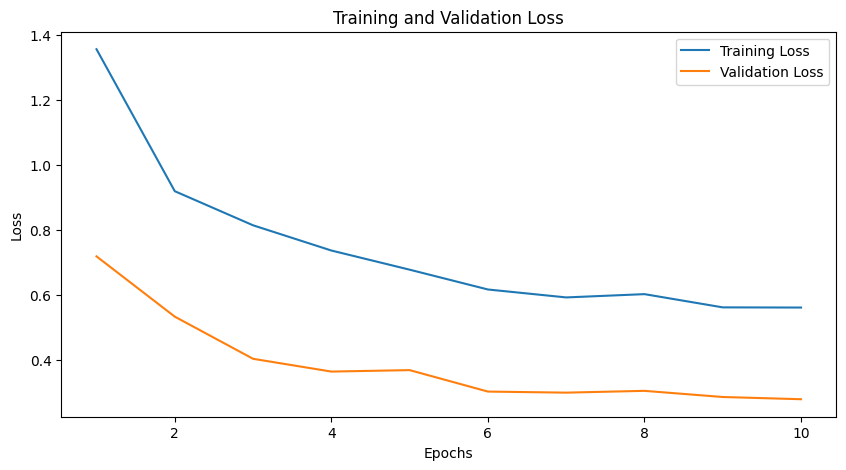

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_densenet2, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_densenet2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(densenet_model2.state_dict(), 'densenet_model2.pth')

**Fourth combination**

In [ ]:
densenet_model3 = densenet121(pretrained=True)

densenet_model3.classifier = nn.Sequential(
    nn.Linear(1024, 10),
    nn.ReLU(True),
    nn.Dropout(0.3),
    nn.Linear(10, 7)
)

densenet_model3.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
densenet_criterion3 = nn.CrossEntropyLoss()
densenet_optimizer3 = torch.optim.Adam(densenet_model3.parameters(), lr=0.1, weight_decay=0.001)

In [ ]:
num_epochs = 10
train_losses_densenet3 = []
val_losses_densenet3 = []
test_losses_densenet3 = []

for epoch in range(num_epochs):
    start_time = time.time()

    densenet_model3.train()
    running_loss_densenet3 = 0.0
    correct_densenet3 = 0
    total_densenet3 = 0

    for inputs, labels in train_loader_densenet1:
        inputs = inputs.to(device)

        labels = labels.to(device)

        densenet_optimizer3.zero_grad()
        outputs = densenet_model3(inputs)
        loss = densenet_criterion3(outputs, labels)
        loss.backward()
        densenet_optimizer3.step()

        running_loss_densenet3 += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_densenet3 += labels.size(0)
        correct_densenet3 += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    train_accuracy_densenet3 = 100 * correct_densenet3 / total_densenet3
    train_loss_densenet3 = running_loss_densenet3 / len(train_loader_densenet1)
    train_losses_densenet3.append(train_loss_densenet3)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_densenet3:.4f}, Train Accuracy: {train_accuracy_densenet3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

    start_time = time.time()

    densenet_model3.eval()
    running_loss_densenet3 = 0
    correct_densenet3 = 0
    total_densenet3 = 0

    with torch.no_grad():
        for inputs, labels in val_loader_densenet1:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = densenet_model3(inputs)
            loss = densenet_criterion3(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total_densenet3 += labels.size(0)
            correct_densenet3 += (predicted == labels).sum().item()

            running_loss_densenet3 += loss

    end_time = time.time()
    elapsed_time = end_time - start_time

    val_loss_densenet3 = running_loss_densenet3 / len(val_loader_densenet1)
    val_losses_densenet3.append(val_loss_densenet3)
    val_accuracy_densenet3 = 100 * correct_densenet3 / total_densenet3

    print(f"Epoch {epoch+1}, Val Loss: {val_loss_densenet3:.4f}, Val Accuracy: {val_accuracy_densenet3:.2f}%")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print("-" * 50)
    print()

In [ ]:
start_time = time.time()

densenet_model3.eval()

running_loss_densenet3 = 0
correct_densenet3 = 0
total_densenet3 = 0
with torch.no_grad():
    for inputs, labels in test_loader_densenet1:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = densenet_model3(inputs)
        loss = densenet_criterion3(outputs, labels).item()

        _, predicted = torch.max(outputs, 1)
        total_densenet3 += labels.size(0)
        correct_densenet3 += (predicted == labels).sum().item()

        running_loss_densenet3 += loss

end_time = time.time()
elapsed_time = end_time - start_time

test_loss_densenet3 = running_loss_densenet3 / len(test_loader_densenet1)
test_losses_densenet3.append(test_loss_densenet3)
test_accuracy_densenet3 = 100 * correct_densenet3 / total_densenet3

print(f"Epoch {epoch+1}, Test Loss: {test_loss_densenet3:.4f}, Test Accuracy: {test_accuracy_densenet3:.2f}%")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print("-" * 50)
print()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_densenet3, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_densenet3, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses_densenet3, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Interface**

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

models_dict = {
    "ResNet50": models.resnet50(pretrained=True),
    "AlexNet": models.alexnet(pretrained=True),
    "VGG16": models.vgg16(pretrained=True),
    "DenseNet": models.densenet121(pretrained=True)
}

num_ftrs = models_dict['VGG16'].classifier[6].in_features
models_dict['VGG16'].classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

num_ftrs1 = models_dict['AlexNet'].classifier[6].in_features
models_dict['AlexNet'].classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs1, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

num_ftrs2 = models_dict['ResNet50'].fc.in_features
models_dict['ResNet50'].fc = nn.Sequential(
    nn.Linear(num_ftrs2, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

num_ftrs3 = models_dict['DenseNet'].classifier.in_features
models_dict['DenseNet'].classifier = nn.Sequential(
    nn.Linear(num_ftrs3, 10),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(10, 7)
)

models_dict["ResNet50"].load_state_dict(torch.load("/content/resnet_model1.pth", map_location=torch.device('cpu')))
models_dict["AlexNet"].load_state_dict(torch.load("/content/alexnet_model1.pth", map_location=torch.device('cpu')))
models_dict["VGG16"].load_state_dict(torch.load("/content/vgg16_model.pth", map_location=torch.device('cpu')))
models_dict["DenseNet"].load_state_dict(torch.load("/content/densenet_model2.pth", map_location=torch.device('cpu')))

preprocess = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Available models:
1. ResNet50
2. AlexNet
3. VGG16
4. DenseNet
Select a model by number: 4
Enter the path to the image: /content/drive/MyDrive/Train_Test_file/Sports_Classes/test/chess/00000464.jpg


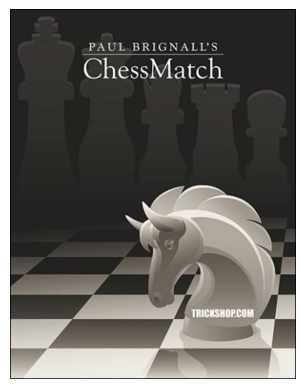

Predicted Class: chess


In [ ]:
classes_name = ["basketball", "chess", "football", "formula1", "gymnastics", "swimming", "wwe"]

def load_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return preprocess(image).unsqueeze(0)

def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    return classes_name[predicted.item()]

def main():
    print("Available models:")
    for i, model_name in enumerate(models_dict.keys(), 1):
        print(f"{i}. {model_name}")

    model_choice = int(input("Select a model by number: "))
    model_name = list(models_dict.keys())[model_choice - 1]
    model = models_dict[model_name]

    image_path = input("Enter the path to the image: ")

    image_tensor = load_image(image_path)

    predicted_class = predict(model, image_tensor)

    print(f"Predicted Class: {predicted_class}")

main()